In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

import sys
sys.path.append( '../src/' )

from ml.preprocessing import *

# Data Preprocessing

## Reading excel sheets

In [2]:
sheets = [ 'Friday 15 May', 'Sunday 24 May', 'Monday 25 May', 'Tuesday 26 May', 
          'Wednesday 27 May', 'Thursday 28 May', 'Friday 29 May', 'Sunday May 31', 
          'Monday June 1', 'Thursday June 4', 'Friday June 5' ]

df = read_sheets( '../datasets/dataset-residential.xlsx', sheets )
df

,pre,alt,hum,tem,ven,occ
date,,,,,,
2020-05-14 21:08:39,94270.77,604.60,54.49,30.99,1.0,L
2020-05-14 21:08:40,94268.36,604.81,54.46,30.99,1.0,L
2020-05-14 21:08:41,94266.11,605.01,54.46,30.99,1.0,L
2020-05-14 21:08:42,94268.52,604.80,54.49,30.99,1.0,L
2020-05-14 21:08:43,94269.70,604.69,54.50,30.99,1.0,L
...,...,...,...,...,...,...
2020-06-05 10:01:23,94731.69,563.99,61.02,30.35,NaN,NaN
2020-06-05 10:01:24,94732.08,563.96,61.01,30.35,NaN,NaN
2020-06-05 10:01:25,94729.84,564.25,61.01,30.35,NaN,NaN


## Removing null values

In [3]:
print( 'Legnth: ', len( df ) )
print( 'Null values:' )
len( df ) - df.count()

Legnth:  353712
Null values:


pre        0
alt        0
hum       97
tem        0
ven    57819
occ    57819
dtype: int64

In [4]:
df = df.dropna( axis = 0, subset = [ 'occ', 'hum' ], thresh = 2 )

In [5]:
print( 'Legnth: ', len( df ) )
print( 'Null values:' )
len( df ) - df.count()

Legnth:  295823
Null values:


pre    0
alt    0
hum    0
tem    0
ven    0
occ    0
dtype: int64

## Visualization

In [ ]:
plot_env_vars( df.index.astype( str ), df[ 'tem' ], df[ 'hum' ], df[ 'occ' ] )
plot_single( df.index.astype( str ), df[ 'pre' ], 'Pressure' )
sns.heatmap( df.corr(), annot = True )

# Datasets Generation

In [10]:
from ml.generation import *
import enum

class DF( enum.Enum ):
    _OR = 0
    _10SEC = 1
    _1MIN = 2
    _5MIN = 3

AGG = [ 'mean' ]
dfs = { DF._10SEC: None, DF._1MIN: None, DF._5MIN: None }
grids = { 
    'svc': { DF._10SEC: None, DF._1MIN: None, DF._5MIN: None },
    'knn': { DF._10SEC: None, DF._1MIN: None, DF._5MIN: None },
    'dt': { DF._10SEC: None, DF._1MIN: None, DF._5MIN: None } }

## Different resolutions generation

### 10 sec. avg.

In [11]:
dfs[ DF._10SEC ] = df_10sec_avg( df.reset_index( drop = False ), AGG ).set_index( 'date' )

### 1 minute samples

In [12]:
dfs[ DF._1MIN ] = df_1min_samples( df )

### 5 minutes samples

In [13]:
dfs[ DF._5MIN ] = df_5min_samples( df )

## Standarization

In [14]:
for k, d in dfs.items() : 
    x_train, x_test, y_train, y_test = standarize( d )
    dfs[ k ] = [ x_train, x_test, y_train, y_test ]

## Class balancing

In [15]:
from imblearn.over_sampling import ADASYN
from collections import Counter

neighborgs = { DF._OR: 1, DF._10SEC: 1, DF._1MIN: 1, DF._5MIN: 1 }
for k, d in dfs.items() :  
    print( 'Before:', k, Counter( d[ Y_TRAIN ] ) )
    dfs[ k ] = balance_df( d, neighborgs[ k ] )
    print( 'After:', k, Counter( dfs[ k ][ Y_TRAIN ] ) )
    print()

Before: DF._10SEC Counter({'L': 16223, 'E': 4084, 'M': 2826, 'H': 536})
After: DF._10SEC Counter({'M': 16256, 'L': 16223, 'H': 16216, 'E': 16200})

Before: DF._1MIN Counter({'L': 2730, 'E': 673, 'M': 480, 'H': 92})
After: DF._1MIN Counter({'E': 2737, 'H': 2732, 'L': 2730, 'M': 2724})

Before: DF._5MIN Counter({'L': 553, 'E': 136, 'M': 96, 'H': 19})
After: DF._5MIN Counter({'M': 558, 'E': 556, 'L': 553, 'H': 551})



# Features Selection

## Recursive Feature Elimination 

In [16]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

## 3.2 Selecting K-best

In [17]:
from sklearn.feature_selection import RFE

# Classification

In [18]:
from ml.classification import *

params_svc = [ { 
    'C': [ .1, 1, 10,  ], 
    'kernel': [ 'linear', 'poly' ] 
}, { 
    'C': [ .1, 1, 10 ], 
    'kernel': [ 'rbf' ],
    'gamma': [ 10, 1, 0.1 ]
} ]

params_knn = [ { 
    'n_neighbors': [ 1, 3, 8, 13 ], 
    'p': [ 1, 2 ], # mikowsky distance
    'algorithm': [ 'brute', 'ball_tree', 'kd_tree' ]
} ]

params_dt = [ { 
    'criterion': [ 'gini', 'entropy' ], 
    'max_depth': [ 2, 3, 4, 6, 8, 10, 11, 12 ]
} ]

## Regular

### SVC

In [20]:
for k, df in dfs.items():
    if( k != DF._10SEC and k != DF._1MIN ):
        print( 'Dataset ', k, len( df ) )
        train_and_test( 
                svm.SVC(), params_svc, 
                df[ X_TRAIN ], df[ Y_TRAIN ], 
                df[ X_TEST ], df[ Y_TEST ] )

Dataset  DF._5MIN 4
Best params:  {'C': 10, 'gamma': 10, 'kernel': 'rbf'}
Training Accuracy 0.964389955566426
Test Accuracy:  0.8955223880597015


### KNN

In [21]:
for k, df in dfs.items():
    if( k != DF._10SEC and k != DF._1MIN ):
        print( 'Dataset ', k )
        train_and_test( KNeighborsClassifier(), params_knn, 
                       df[ X_TRAIN ], df[ Y_TRAIN ], 
                       df[ X_TEST ], df[ Y_TEST ] )

Dataset  DF._5MIN
Best params:  {'algorithm': 'brute', 'n_neighbors': 1, 'p': 2}
Training Accuracy 0.9801689698748524
Test Accuracy:  0.9253731343283582


### DT

In [22]:
for k, df in dfs.items():
    if( k != DF._10SEC and k != DF._1MIN ):
        print( 'Dataset ', k )
        train_and_test( DecisionTreeClassifier(), params_dt, 
                       df[ X_TRAIN ], df[ Y_TRAIN ], 
                       df[ X_TEST ], df[ Y_TEST ] )

Dataset  DF._5MIN
Best params:  {'criterion': 'gini', 'max_depth': 11}
Training Accuracy 0.9637091842974197
Test Accuracy:  0.9104477611940298


## PCA

### SVC

In [23]:
for k, df in dfs.items():
    if( k != DF._10SEC and k != DF._1MIN ): 
        print( 'Dataset ', k )
        grids[ 'svc' ][ k ] = train_and_test( 
                add_pca_estimator( svm.SVC() ), 
                prefix_params( params_svc, 'clf' ), 
                df[ X_TRAIN ], df[ Y_TRAIN ], 
                df[ X_TEST ], df[ Y_TEST ] )

Dataset  DF._5MIN
Best params:  {'clf__C': 10, 'clf__gamma': 10, 'clf__kernel': 'rbf'}
Training Accuracy 0.9528973543679428
Test Accuracy:  0.8805970149253731


### KNN

In [24]:
for k, df in dfs.items():
    if( k != DF._10SEC and != DF._1MIN ):
        print( 'Dataset ', k )
        grids[ 'knn' ][ k ] = train_and_test( 
                    add_pca_estimator( KNeighborsClassifier() ), 
                    prefix_params( params_knn, 'clf' ), 
                    df[ X_TRAIN ], df[ Y_TRAIN ], 
                    df[ X_TEST ], df[ Y_TEST ] )

Dataset  DF._1MIN
Best params:  {'clf__algorithm': 'brute', 'clf__n_neighbors': 1, 'clf__p': 2}
Training Accuracy 0.9919435284142514
Test Accuracy:  0.9647887323943662
Dataset  DF._5MIN
Best params:  {'clf__algorithm': 'brute', 'clf__n_neighbors': 1, 'clf__p': 2}
Training Accuracy 0.9758856141209081
Test Accuracy:  0.9104477611940298


### DT

In [25]:
for k, df in dfs.items():
    if( k != DF._10SEC and != DF._1MIN ):
        print( 'Dataset ', k )
        grids[ 'dt' ][ k ] = train_and_test( 
            add_pca_estimator( DecisionTreeClassifier() ), 
            prefix_params( params_dt, 'clf' ), 
            df[ X_TRAIN ], df[ Y_TRAIN ], 
            df[ X_TEST ], df[ Y_TEST ] )

Dataset  DF._1MIN
Best params:  {'clf__criterion': 'entropy', 'clf__max_depth': 12}
Training Accuracy 0.9784397213033993
Test Accuracy:  0.9285714285714286
Dataset  DF._5MIN
Best params:  {'clf__criterion': 'gini', 'clf__max_depth': 12}
Training Accuracy 0.944781093310505
Test Accuracy:  0.8606965174129353


# Evaluation

In [26]:
from ml.evaluation import *

## Learning Curves

### SVC

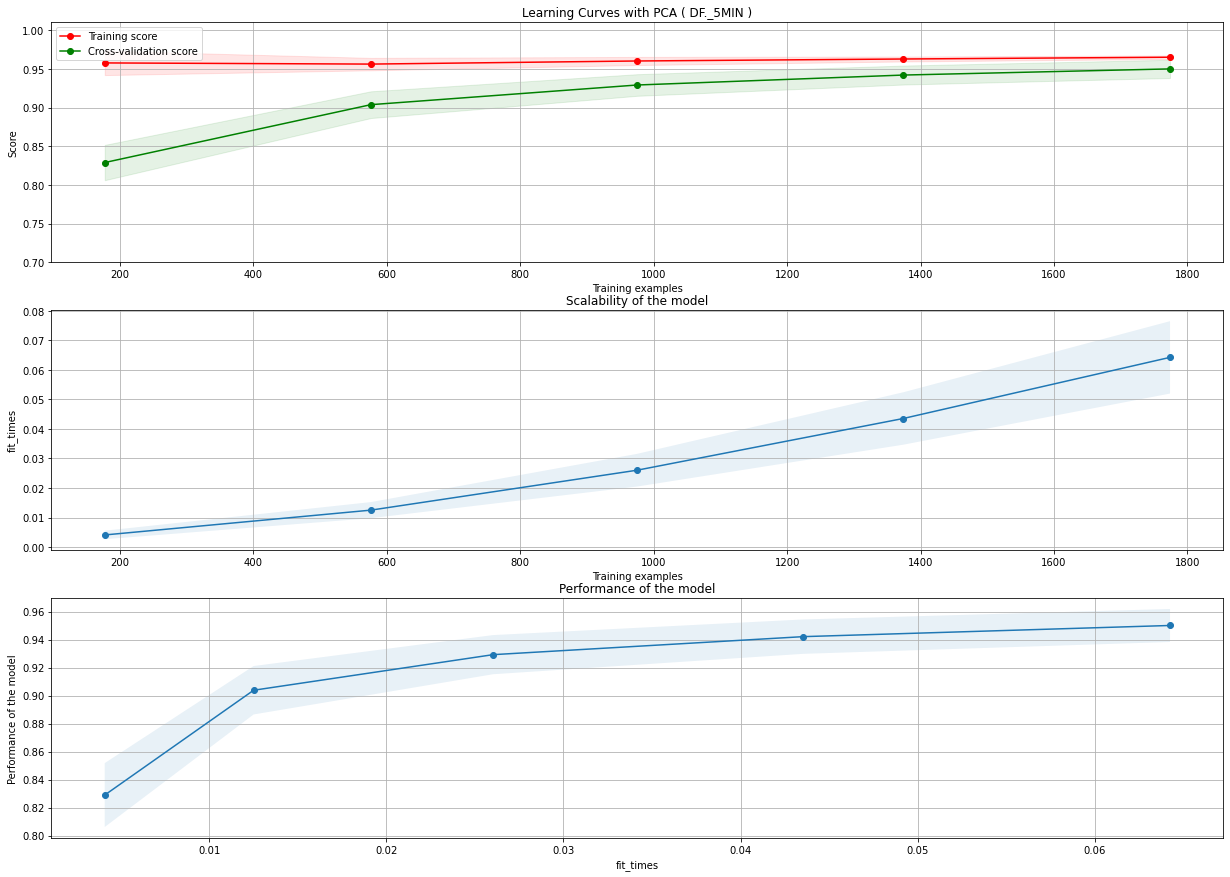

In [27]:
temp = [ item for item in dfs.items() if item[ 0 ] not in [ DF._10SEC, DF._1MIN ] ]
plot_learning_curves( temp, grids[ 'svc' ] )

### KNN

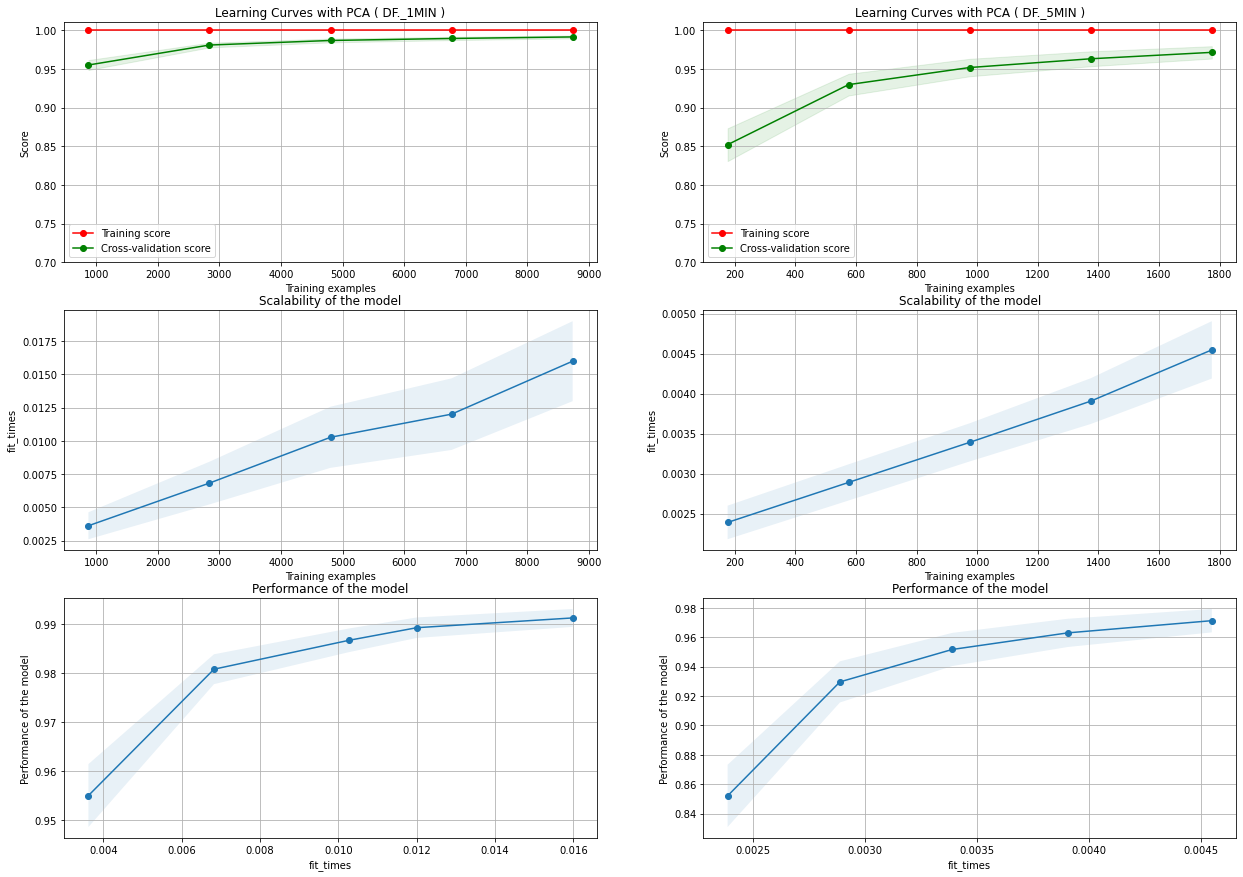

In [28]:
temp = [ item for item in dfs.items() if item[ 0 ] != DF._10SEC ]
plot_learning_curves( temp, grids[ 'knn' ] )

### DT

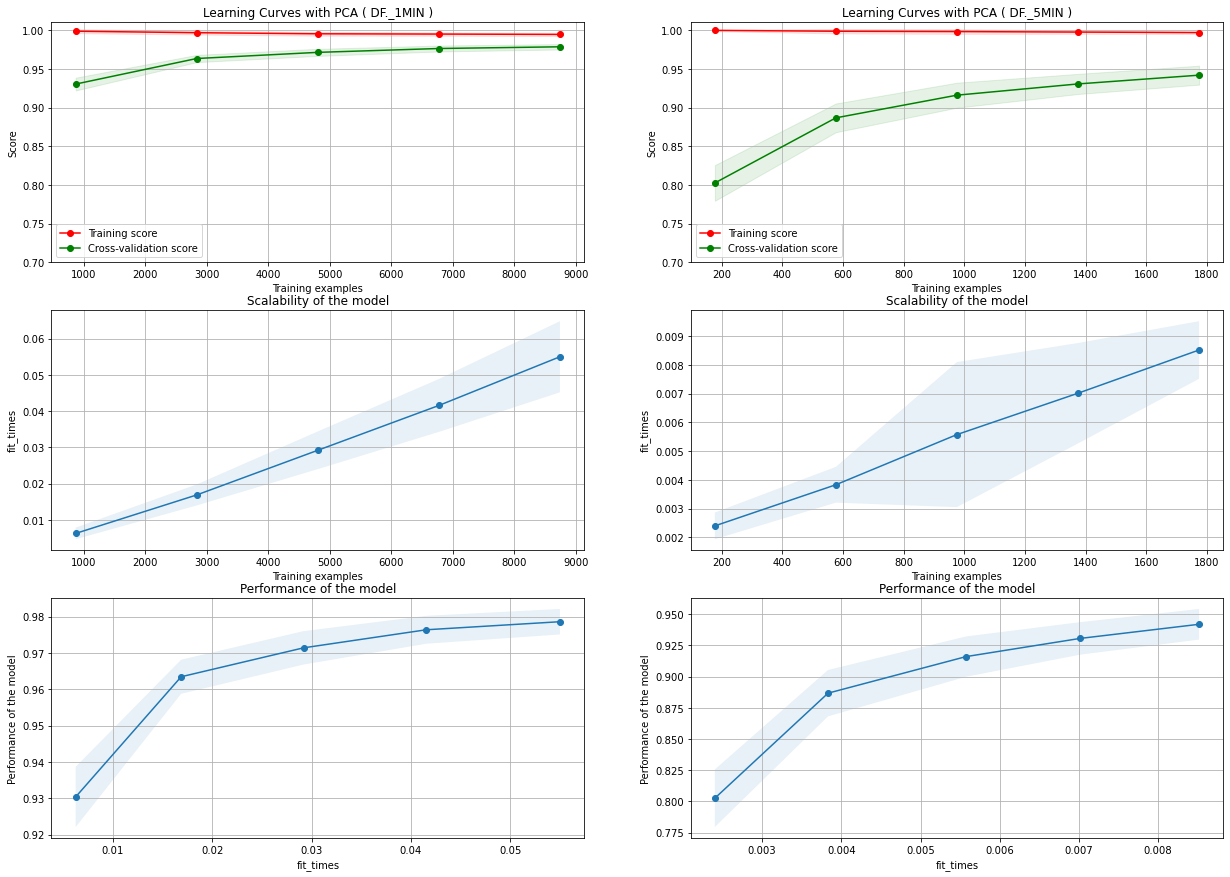

CPU times: user 4.46 s, sys: 323 ms, total: 4.78 s
Wall time: 9.66 s


In [31]:
%%time
temp = [ item for item in dfs.items() if item[ 0 ] != DF._10SEC ]
plot_learning_curves( temp, grids[ 'dt' ] )